/tmp/ipykernel_13928/1341906687.py:13: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/complaints.csv")


Shape of full dataset: (2413504, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2413504 entries, 0 to 2413503
Data columns (total 18 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Date received                 object 
 1   Product                       object 
 2   Sub-product                   object 
 3   Issue                         object 
 4   Sub-issue                     object 
 5   Consumer complaint narrative  object 
 6   Company public response       object 
 7   Company                       object 
 8   State                         object 
 9   ZIP code                      object 
 10  Tags                          object 
 11  Consumer consent provided?    object 
 12  Submitted via                 object 
 13  Date sent to company          object 
 14  Company response to consumer  object 
 15  Timely response?              object 
 16  Consumer disputed?            object 
 17  Complaint ID                

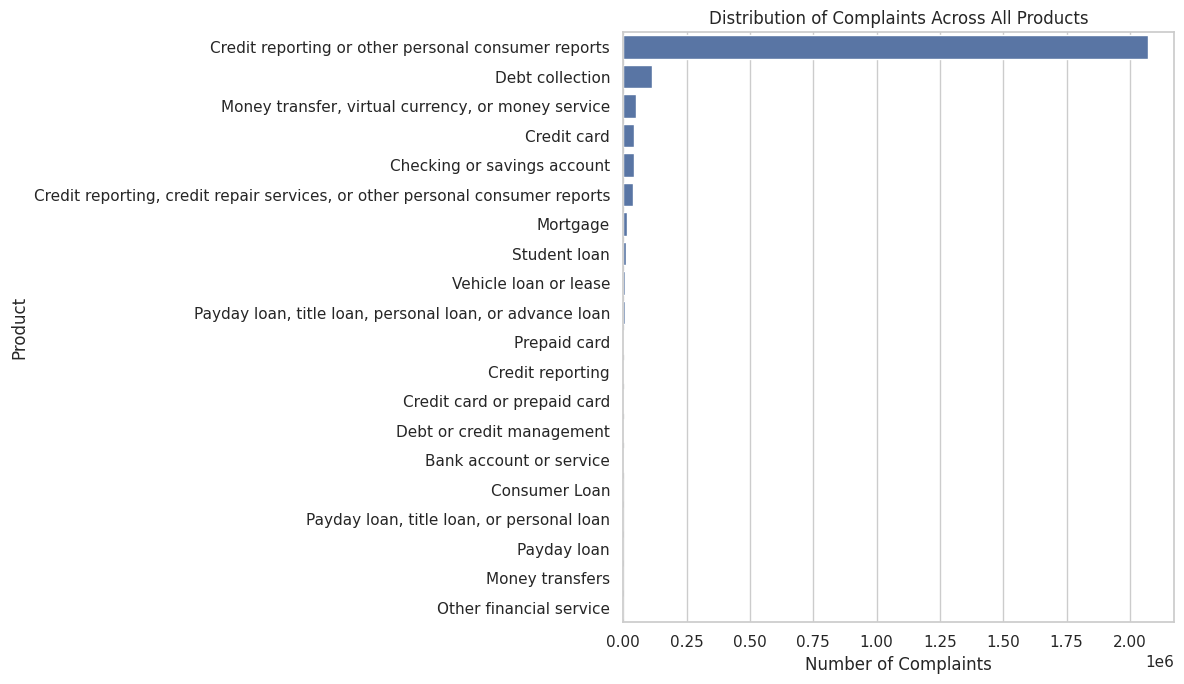

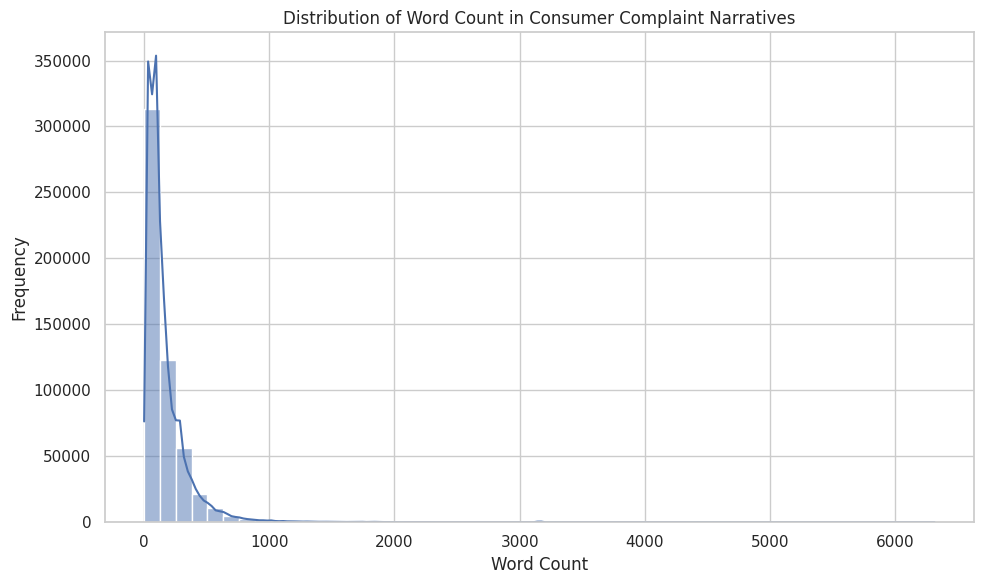


Complaints with narrative: 537724
Complaints without narrative: 1875780

✅ Filtered & cleaned data saved to: data/filtered_complaints.csv

Filtered dataset shape: (16212, 21)
Top products in filtered set:
Product
Credit card        16188
Money transfers       24
Name: count, dtype: int64


In [9]:
# notebooks/1_eda_preprocessing.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Display settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

# Load full dataset
df = pd.read_csv("../data/complaints.csv")
print("Shape of full dataset:", df.shape)

# Overview
df.info()
print("\nMissing values per column:")
print(df.isnull().sum())

# ----------------------
# 1. EDA on Full Dataset
# ----------------------

# Complaint distribution across all products
plt.figure(figsize=(12, 7))
sns.countplot(y="Product", data=df, order=df["Product"].value_counts().index)
plt.title("Distribution of Complaints Across All Products")
plt.xlabel("Number of Complaints")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

# Add word count column (raw narratives)
df["Narrative Word Count"] = df["Consumer complaint narrative"].dropna().apply(lambda x: len(str(x).split()))
df["Has Narrative"] = df["Consumer complaint narrative"].notna() & (df["Consumer complaint narrative"].str.strip() != "")

# Word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(df[df["Has Narrative"]]["Narrative Word Count"], bins=50, kde=True)
plt.title("Distribution of Word Count in Consumer Complaint Narratives")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Number of complaints with and without narratives
has_narrative = df["Has Narrative"].sum()
without_narrative = len(df) - has_narrative
print("\nComplaints with narrative:", has_narrative)
print("Complaints without narrative:", without_narrative)

# ------------------------------
# 2. Filter + Preprocess for RAG
# ------------------------------

# Filter only relevant products
target_products = [
    "Credit card", "Personal loan", "Buy Now, Pay Later",
    "Savings account", "Money transfers"
]
df_filtered = df[df["Product"].str.strip().str.lower().isin([p.lower() for p in target_products])]

# Drop rows with missing/empty narratives
df_filtered = df_filtered[df_filtered["Consumer complaint narrative"].notna()]
df_filtered = df_filtered[df_filtered["Consumer complaint narrative"].str.strip() != ""]

# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply cleaning
df_filtered["Cleaned Narrative"] = df_filtered["Consumer complaint narrative"].apply(clean_text)
df_filtered["Narrative Word Count"] = df_filtered["Cleaned Narrative"].str.split().apply(len)

# Save filtered/cleaned data
df_filtered.to_csv("../data/filtered_complaints.csv", index=False)
print("\n✅ Filtered & cleaned data saved to: data/filtered_complaints.csv")

# Optional quick check
print("\nFiltered dataset shape:", df_filtered.shape)
print("Top products in filtered set:")
print(df_filtered["Product"].value_counts())
